In [53]:
# Подключаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

# Описание исследования

**«Стримчик»** - интернет-магазин, который продаёт по всему миру компьютерные игры.

Необходимо, используя исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы, <u>выявить определяющие успешность игры закономерности</u>. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года. Необходимо построить принцип прогнозирования из года в год.

**ESRB** (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных

**ESRB** — Entertainment Software Rating Board — Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Столбец         | Значение
:-------------- | :-------------
Name            | название игры
Platform        | платформа
Year_of_Release | год выпуска
Genre           | жанр игры
NA_sales        | продажи в Северной Америке (миллионы проданных копий)
EU_sales        | продажи в Европе (миллионы проданных копий)
JP_sales        | продажи в Японии (миллионы проданных копий)
Other_sales     | продажи в других странах (миллионы проданных копий)
Critic_Score    | оценка критиков (максимум 100)
User_Score      | оценка пользователей (максимум 10)
Rating          | рейтинг от организации ESRB

## Получение данных

In [3]:
# Открываем файл с данными
df = pd.read_csv('/datasets/games.csv')

# Смотрим на содержимое
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Видим явное наличие пропусков, необходимость преобразования названий столбцов к нижнему регистру, а также преобразования типов данных.

## Предобработка данных

### Замена названий столбцов

In [5]:
# Подготовим словарь для преобразования названий столбцов к нижнему регистру
col_to_rename = {}
for col in df.columns:
    col_to_rename[col] = str.lower(col)
    
# Переименовываем названия столбцов
df = df.rename(columns=col_to_rename)

# Проверяем результат
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных и обработка пропусков

#### Столбец name

Видим всего лишь 2 пропуска в данном столбце, которые очевидно объясняются простой потерей данных. Оценивать игру без названия не имеет смысла, поэтому уберем данные пропуски из рассмотрения.

In [6]:
df = df.dropna(subset=['name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


#### Столбец year_of_release

`year_of_release` - Пропуски в данном столбце могли возникнуть по причине технического сбоя, умышленного утаивания информация со стороны владельца игры или же игра ещё не была выпущена. Заполним пропуски нулями, чтобы в будущем оценить как отсутствие указанного года релиза влияет на показатели, и приведем к типу `int`, поскольку год незачем хранить в типе `float`.

In [7]:
# Заполняем пропуски
df['year_of_release'] = df['year_of_release'].fillna(0)

# Преобразовываем тип данных
df['year_of_release'] = df['year_of_release'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Пропуски в `year_of_release` устранены, тип данных приведен к корректному.

#### Столбец user_score

_**TBD** - аббревиатура от английского To Be Determined (будет определено). Означает, что игра ещё не оценена достаточным количеством пользователей._

`user_score` - Принимает значения от 0 до 10, а также _tbd_. Пропуски в данном столбце могут объясняться потерей данных или нежеланием пользователей оценивать игру. 

Данные в данном столбце можно категоризовать по 3 типам: с оценкой (`with_score`), без оценки (`without_score`) и будет определено (`tbd`). 

Сформируем новый столбец `score_type`, который будет содержать информацию о типе оценки пользователей. Далее, для дальнейшего корректного анализа, заменим пропуски и оценку _tbd_ нулями и приведем тип данных в столбце user_score к типу `float`.

In [8]:
def detect_user_score_type(score):
    '''
        Функция определяет тип оценки пользователя по значению оценки.
    '''
    if score == 'tbd':
        return 'tbd'
    if not pd.isna(score):
        return 'with_score'
    return 'without_score'

In [9]:
# Создаём новый столбец и определяем тип оценки
df['user_score_type'] = df['user_score'].apply(detect_user_score_type)

# Заменяем пропуски и tbd нулями
df['user_score'] = df['user_score'].fillna(0)
df.loc[df['user_score'] == 'tbd', 'user_score'] = 0

# Преобразовываем тип данных
df['user_score'] = df['user_score'].astype(float)

# Смотрим на результат
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,user_score_type
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,with_score
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,0.0,NaN,without_score
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,with_score
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,with_score
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,0.0,NaN,without_score


Столбец с типом оценки успешно сформирован. Столбец `user_score` приведен к корректному типу данных.

In [10]:
df['user_score_type'].value_counts()

with_score       7590
without_score    6699
tbd              2424
Name: user_score_type, dtype: int64

Как видим, записи без оценки составляют около 40% от всех данных, поэтому решение о категоризации было принято верно.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16713 non-null  float64
 10  rating           9949 non-null   object 
 11  user_score_type  16713 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.7+ MB


Пропуски в столбце `user_score` заполнены, тип данных приведен к корректному.

#### Столбец critic_score

Посмотрим на распределение данных.

In [12]:
df['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Оценка критиков принимает значения от 13 до 98. В столбце имеется много пропусков. Пропуски объясняются вероятно тем, что игра не вышла на необходимый уровень, чтобы её начали оценивать критики. Пропуски в данном столбце говорят о многом, поэтому заполнять их средними значениями не стоит.

Создадим новый столбец `critic_score_type`, в котором будет храниться информация о наличии или отсутствии оценки критиков. Далее заполним пропуски в столбце `critic_score` нулями и приведём тип данных к `int`, поскольку значения оценок принимают только целые значения.

In [13]:
# Создаём новый столбец с типом оценки критиков
df['critic_score_type'] = df['critic_score'].apply(lambda x: 'with_score' if not pd.isna(x) else 'without_score')

# Заполняем пропуски в столбце critic_score нулями и приводим тип данных к int
df['critic_score'] = df['critic_score'].fillna(0)
df['critic_score'] = df['critic_score'].astype(int)

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,user_score_type,critic_score_type
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,with_score,with_score
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,NaN,without_score,without_score
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,with_score,with_score
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,with_score,with_score
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,NaN,without_score,without_score


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16713 non-null  object 
 1   platform           16713 non-null  object 
 2   year_of_release    16713 non-null  int64  
 3   genre              16713 non-null  object 
 4   na_sales           16713 non-null  float64
 5   eu_sales           16713 non-null  float64
 6   jp_sales           16713 non-null  float64
 7   other_sales        16713 non-null  float64
 8   critic_score       16713 non-null  int64  
 9   user_score         16713 non-null  float64
 10  rating             9949 non-null   object 
 11  user_score_type    16713 non-null  object 
 12  critic_score_type  16713 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 1.8+ MB


Новый столбец с типом оценки критиков успешно сформирован, пропуски в столбце `critic_score` заполнены, данные приведены к корректному типу.

#### Столбец rating

Посмотрим какие значения имеются в данном столбце.

In [15]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

<i> Краткая справка из интернета:
    
«E» («Everyone») — «Для всех» все возраста
    
«EC» («Early childhood») — «Для детей младшего возраста» от 3 лет
    
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»

«T» («Teen») — «Подросткам» от 13 лет

«M» («Mature») — «Для взрослых» от 17 лет

«AO» («Adults Only 18+») — «Только для взрослых» от 18 лет

«RP» («Rating Pending») — «Рейтинг ожидается» демо-версии игр

«K-A» (Kids to Adults) — первоначальное обозначение «E» («Everyone»), с 6 лет</i>

Заменим устаревшее обозначение `K-A` на современное `E`, поскольку нет смысла рассматривать данные 3 записи как отдельную категорию.

In [16]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'
df['rating'].value_counts()

E       3993
T       2961
M       1563
E10+    1420
EC         8
RP         3
AO         1
Name: rating, dtype: int64

Ассоциация _ESRB_ была создана в 1994 году. Вполне объяснимо, что игры созданные до создания ассоциации могли не пройти оценку. 

Вот некоторые другие причины, по которым не все игры проходят оценку от данной ассоциации:

- Большое количество игр. ESRB не может оценить их все, так как для этого требуется слишком много времени.
- Платность лицензии. За оценку игры ESRB издателю нужно заплатить, стоимость лицензии может составлять от трёх тысяч долларов и более в зависимости от бюджета игры.
- Необходимость предоставить дополнительные материалы. Для оценки игры нужно предоставить клипы с игровым процессом, письменные обзоры игры и любого возможного нежелательного контента в ней.

Пропуски в данном столбце говорят о многом, поэтому, так как столбец имеет корректный тип данных, оставим пропуски без изменений.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16713 non-null  object 
 1   platform           16713 non-null  object 
 2   year_of_release    16713 non-null  int64  
 3   genre              16713 non-null  object 
 4   na_sales           16713 non-null  float64
 5   eu_sales           16713 non-null  float64
 6   jp_sales           16713 non-null  float64
 7   other_sales        16713 non-null  float64
 8   critic_score       16713 non-null  int64  
 9   user_score         16713 non-null  float64
 10  rating             9949 non-null   object 
 11  user_score_type    16713 non-null  object 
 12  critic_score_type  16713 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 1.8+ MB


### Суммарные продажи во всех регионах

Создадим новый столбец `total_sales`, в котором будет хранится информация о суммарных продажах иргы во всех регионах.

In [18]:
# Создаём новый столбец с сумарными продажами
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,user_score_type,critic_score_type,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,with_score,with_score,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,NaN,without_score,without_score,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,with_score,with_score,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,with_score,with_score,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,NaN,without_score,without_score,31.38


In [19]:
df['total_sales'].describe()

count    16713.000000
mean         0.533315
std          1.548282
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

### Промежуточные выводы

- Из данных были удалены 2 записи, содержащие пропуск в названии игры
- В приблизительно 300 записей отсутствует информация о годе релиза
- Имеется около 50% записей с оценкой пользователей, 40% без оценки пользователей и 10% с оценкой _tbd_
- Приблизительно у половины игр отсутствует оценка от критиков
- Записи с устаревшим рейтингом `K-A` были заменены на современный `E`
- Рейтинг имеется у приблизительно 60% игр
- Максимальное количество продаж составляет 82.5 млн копий

## Исследовательский анализ данных

### Количество выпущенных игр за разные годы

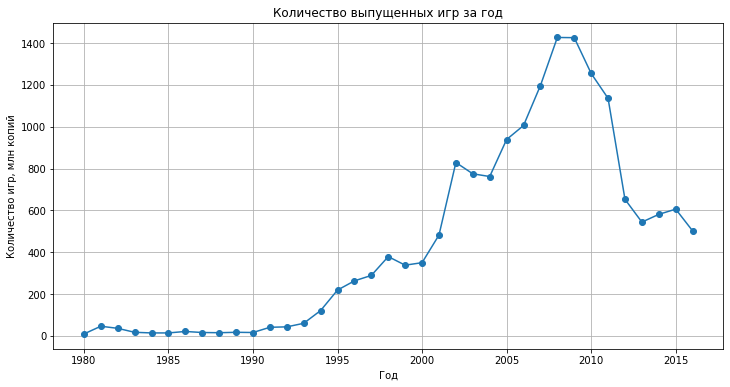

In [20]:
(
    df.query('year_of_release > 0')
      .groupby('year_of_release')['name'].count()
      .plot(
          style='o-',
          figsize=(12,6),
          grid=True,
          title='Количество выпущенных игр за год',
          xlabel='Год',
          ylabel='Количество игр, млн копий'
      )
);

С 1980 по 1990 годы количество выпускаемых игр было очень маленьким и оставалось на примерно одинаковом уровне. С 1990 по 2008 год происходит достаточно резкий рост с явным пиком в 2002 году и небольшим спадом после него. 

Так как данных до 1990 очень мало, не имеет смысла брать их в рассмотрение.

### Продажи по платформам

Посмотрим на суммарные продажи по платформам.

In [21]:
platforms_sales = df.groupby('platform')['total_sales'].sum()
                    .sort_values(ascending=False).reset_index()
platforms_sales

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


Самые большие продажи были у _PS2_, а самые маленькие у _PCFX_. 

Возьмем топ 10 платформ с самыми большими суммарными продажами и построим распределение по годам.

In [22]:
platforms_top_10 = platforms_sales.loc[:9, 'platform']
platforms_top_10

0     PS2
1    X360
2     PS3
3     Wii
4      DS
5      PS
6     GBA
7     PS4
8     PSP
9      PC
Name: platform, dtype: object

Построим график, отображающий распределение продаж по годам по топ 10 платформам.

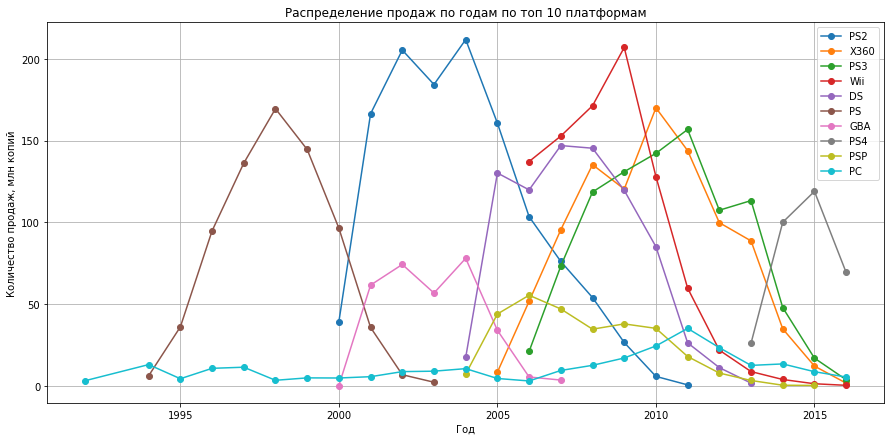

In [23]:
for platform in platforms_top_10:
    df.query('platform == @platform and year_of_release > 1990') \
      .groupby('year_of_release')['total_sales'].sum() \
      .plot(
        style='o-',
        grid=True,
        figsize=(15,7),
        label=platform
      )
 
plt.title('Распределение продаж по годам по топ 10 платформам')
plt.xlabel('Год')
plt.ylabel('Количество продаж, млн копий')
plt.legend();

Замечаем тендецию - примерно каждые 5 лет исчезают старые платформы и появляются новые. При этом одна платформа в среднем существует около 10 лет.

### Актуальный период

Последняя смена периодов, предшествующая 2017 году, приходится на 2012-2013 годы. Не имеет смысла рассматривать период до 2013 года, поскольку тогда на рынке была совсем другая ситуация. Выберем за актуальный период 2013-2016 годы для построения прогноза.

Отсекаем актуальный период и далее будем работать с ним.

In [24]:
act_df = df.query('year_of_release >= 2013').reset_index(drop=True)
act_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,user_score_type,critic_score_type,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,with_score,with_score,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,with_score,with_score,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,NaN,without_score,without_score,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0,0.0,NaN,without_score,without_score,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,with_score,with_score,12.62


### Лидирующие платформы

Посмотрим на продажи по платформам в актуальном периоде.

In [25]:
act_df.groupby(['platform'])['total_sales'].mean() \
      .sort_values(ascending=False).reset_index()

,platform,total_sales
0,PS4,0.801378
1,X360,0.735484
2,XOne,0.645020
3,Wii,0.593913
4,WiiU,0.562000
5,PS3,0.525884
6,3DS,0.472772
7,PC,0.208624
8,DS,0.192500
9,PSV,0.092151


Построим график, отображающий распределение средних продаж по платформам в актуальном периоде.

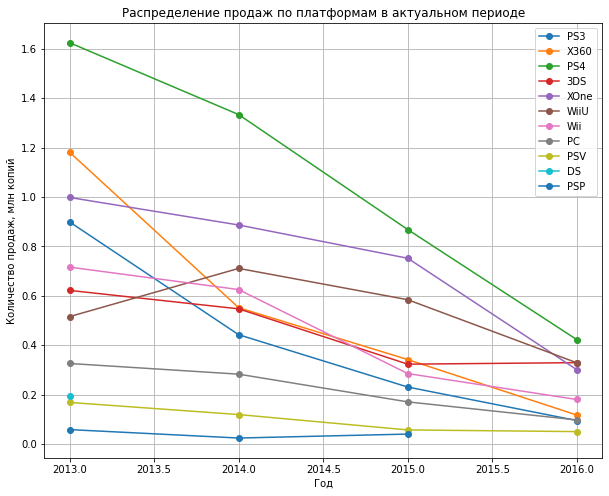

In [26]:
for platform in act_df['platform'].unique():
    act_df.query('platform == @platform') \
          .groupby('year_of_release')['total_sales'].mean() \
          .plot(
            style='o-',
            grid=True,
            figsize=(10,8),
            label=platform
          )
 
plt.title('Распределение средних продаж по платформам в актуальном периоде')
plt.xlabel('Год')
plt.ylabel('Количество продаж, млн копий')
plt.legend();

По продажам в актуальном периоде лидируют следующие платформы: `PS4`, `XOne`, `X360` и `WiiU`. Только `WiiU` в начале периода показывала тенденцию на рост продаж. Однако за весь период все платформы показывают только тенденцию на спад. Потенциально прибыльными платформами могут быть по прежнему `PS4` и `WiiU`, которые находятся на пике в конце рассматриваемого периода, а также `3DS`, которая показывает небольшую тенденцию на рост за последний год и также находится на пике в конце периода.

### Глобальные продажи игр

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

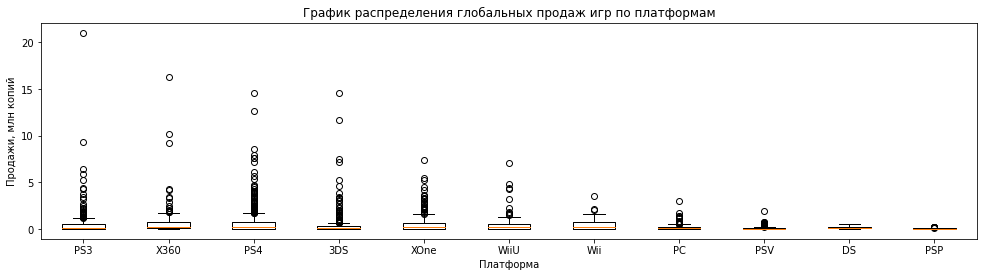

In [27]:
# Создаем список с названиями платформ из актуального периода
act_platforms = [x for x in act_df['platform'].unique()]

# Создаем набор данных для построения графиков
data = [act_df.query('platform == @x')['total_sales'] for x in act_platforms]

fig = plt.figure(figsize =(13, 3))

ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data)

# Подписываем значения на оси X
ax.set_xticklabels(act_platforms)

plt.title('График распределения глобальных продаж игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн копий')
plt.show();

Видим, что платформы `PS3`, `PS4`, `X360` и `3DS` выбиваются по продажам. Их значения продаж доходят до 15-20 млн копий. Мы не можем убрать данные записи из рассмотрения или преобразовать их, поскольку такие значения хоть и выбиваются, но вполне могут оказаться реальными, с учетом всего населения земли.

Для того, чтобы сделать более четкие выводы, посмотрим на данный график поближе, ограничив ось Y.

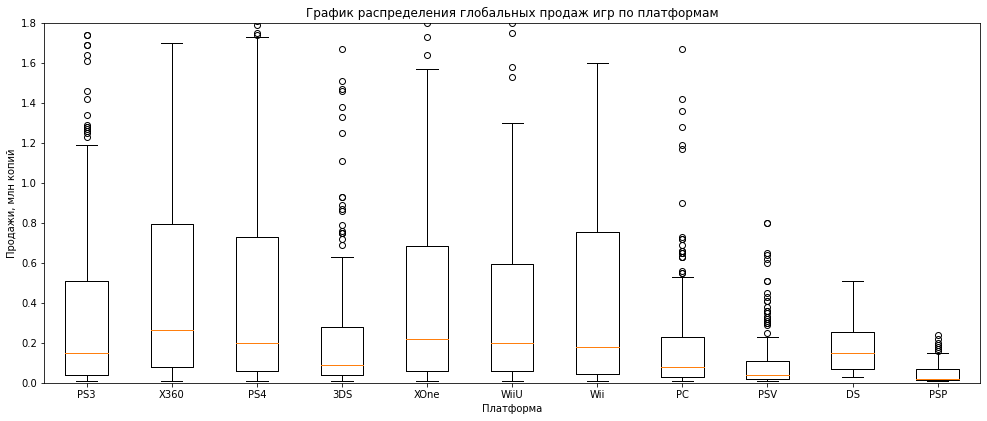

In [28]:
fig = plt.figure(figsize =(13, 5))

ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data)

# Подписываем значения на оси X
ax.set_xticklabels(act_platforms)

# Ограничиваем ось Y значением 1.8 млн копий
plt.ylim(0, 1.8)

plt.title('График распределения глобальных продаж игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн копий')
plt.show();

Видим, что в среднем продажи в актуальном периоде по всем платформам находятся на уровне около 0.2 млн копий или 200 тысяч копий. При этом верхняя граница 99% всех продаж не превышает 1.8 млн копий. Самое высокое среднее значение продаж у платформы `X360`, а самое низкое у `PSP`.

### Продажи в зависимости от отзывов

Посмотрим как влияют на продажи отзывы пользователей и критиков на одной из самых популярных платформ `PS3`. Для начала посмотрим на количество записей.

In [29]:
ps3_df = act_df.query('platform == "PS3"')
ps3_df.shape[0]

345

Имеется 345 записей. Посмотрим на корреляцию между оценкой пользователей и продажами.

In [30]:
# Выберем только записи с имеющейся оценкой от пользователей
ps3_with_user_score = ps3_df.query('user_score_type == "with_score"')

# Посмотрим на значение корреляции
ps3_with_user_score['user_score'].corr(ps3_with_user_score['total_sales'])

0.0023944027357566925

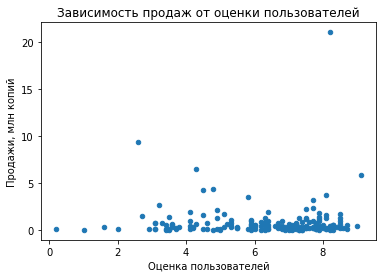

In [31]:
ps3_with_user_score.plot.scatter(
    x='user_score', 
    y='total_sales',
    title='Зависимость продаж от оценки пользователей',
    xlabel='Оценка пользователей',
    ylabel='Продажи, млн копий'
);

Можно смело говорить об отсутствии связи.

Посмотрим на корреляцию между оценкой критиков и продажами.

In [32]:
# Выберем только записи с имеющейся оценкой от критиков
ps3_with_critic_score = ps3_df.query('critic_score_type == "with_score"')

# Посмотрим на значение корреляции
ps3_with_critic_score['critic_score'].corr(ps3_with_critic_score['total_sales'])

0.3342853393371919

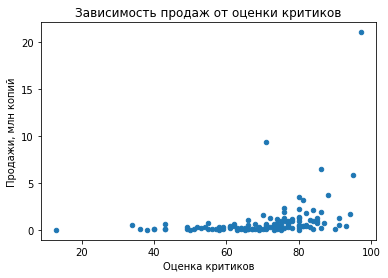

In [33]:
ps3_with_critic_score.plot.scatter(
    x='critic_score', 
    y='total_sales',
    title='Зависимость продаж от оценки критиков',
    xlabel='Оценка критиков',
    ylabel='Продажи, млн копий'
);

В данном случае наблюдаем небольшую корреляцию в прямом направлении, то есть чем выше оценка от критиков, тем больше продаж. Однако связь не сильная.

Посмотрим на продажи в зависимости от типа оценки пользователей и критиков.

In [34]:
ps3_df.groupby('user_score_type')['total_sales'].mean()

user_score_type
tbd              0.057826
with_score       0.818011
without_score    0.205515
Name: total_sales, dtype: float64

In [35]:
ps3_df.groupby('critic_score_type')['total_sales'].mean()

critic_score_type
with_score       0.942727
without_score    0.300714
Name: total_sales, dtype: float64

Видим, что в среднем больше продаж происходит по играм с оценками, чем по играм без оценок.

Посмотрим на продажи в зависимости от оценки по всем платформам.

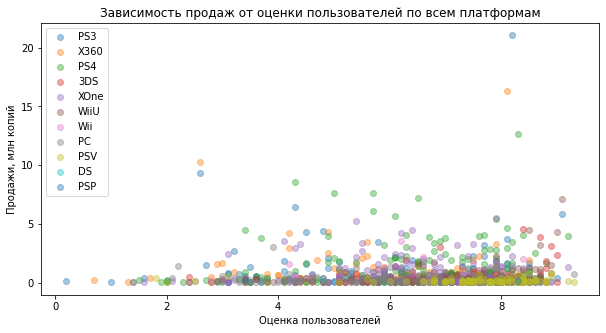

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))

# Выберем только игры с существующей оценкой от пользователей
# Для каждой платформы в аткуальном периоде построим график рассеяния
for platform in act_platforms:
    data = act_df.query('platform == @platform') \
                 .query('user_score_type == "with_score"')
    plt.scatter(x=data['user_score'], y=data['total_sales'], alpha=0.4, label=platform)
    
plt.title('Зависимость продаж от оценки пользователей по всем платформам')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн копий')
plt.legend(loc='upper left')
plt.show();

Наблюдаем отсутствие четкой связи, продажи вырываются вверх не зависимо от оценки пользователей.

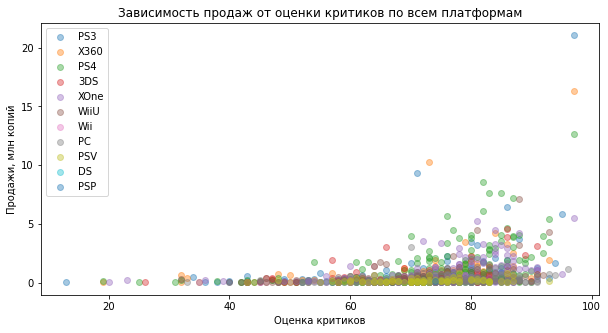

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))

# Выберем только игры с существующей оценкой от критиков
# Для каждой платформы в аткуальном периоде построим график рассеяния
for platform in act_platforms:
    data = act_df.query('platform == @platform') \
                 .query('critic_score_type == "with_score"')
    plt.scatter(x=data['critic_score'], y=data['total_sales'], alpha=0.4, label=platform)
    
plt.title('Зависимость продаж от оценки критиков по всем платформам')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн копий')
plt.legend(loc='upper left')
plt.show();

Видим, что в действительности, чем выше оценка критиков, тем продажи постепенно начинают расти.

Сравним среднюю оценку критиков топовых платформ и их продажи.

In [38]:
# Находим средние значения продаж по платформам
total_sales_mean = act_df.groupby('platform')['total_sales'].mean() \
                         .round(2).sort_values(ascending=False).reset_index()

# Находим среднюю оценку критиков по платформам
critic_score_mean = act_df.query('critic_score_type == "with_score"') \
                          .groupby('platform')['critic_score'].mean().round(2)

# Объединяем данные в одну таблицу
total_sales_mean.merge(critic_score_mean, on='platform')

,platform,total_sales,critic_score
0,PS4,0.80,72.09
1,X360,0.74,69.23
2,XOne,0.65,73.33
3,WiiU,0.56,71.64
4,PS3,0.53,70.20
5,3DS,0.47,68.34
6,PC,0.21,75.55
7,PSV,0.09,71.64
8,PSP,0.05,74.00


Видим, что для первых 6 записей оценка критиков действительно постепенно растёт вместе с продажами. Платформа `PC` к 2016 году перестала существовать, а у платформ `PSP` и `PSV` слишком мало продаж, чтобы делать по ним выводы.

### Распределение игр по жанрам

Посмотрим какие жанры существуют.

In [39]:
act_df['genre'].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Misc', 'Sports', 'Fighting',
       'Racing', 'Simulation', 'Platform', 'Strategy', 'Adventure',
       'Puzzle'], dtype=object)

В данных имеется 12 типов жанра, неявные дубликаты не присутствуют.

Посмотрим на распределение количества игр по жанрам.

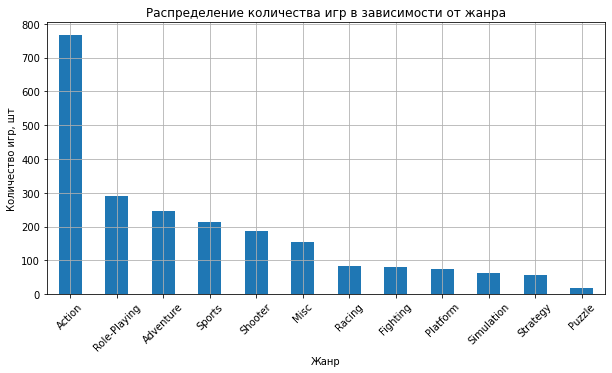

In [40]:
(
    act_df.groupby('genre')['name'].count().sort_values(ascending=False)
          .plot(
              kind='bar',
              grid=True,
              figsize=(10,5),
              rot=45,
              title='Распределение количества игр в зависимости от жанра',
              xlabel='Жанр',
              ylabel='Количество игр, шт'
          )
);

Самый популярный жанр по количеству выпущенных игр это _Action_, далее следует _Role-Playing_, а самый непопулярный - _Puzzle_. Самое большое количество созданных игр у жанра _Action_ - около 750 шт., а самое маленькое у _Puzzle_ - менее 50 шт.

Посмотрим на уровень продаж в зависимости от жанра.

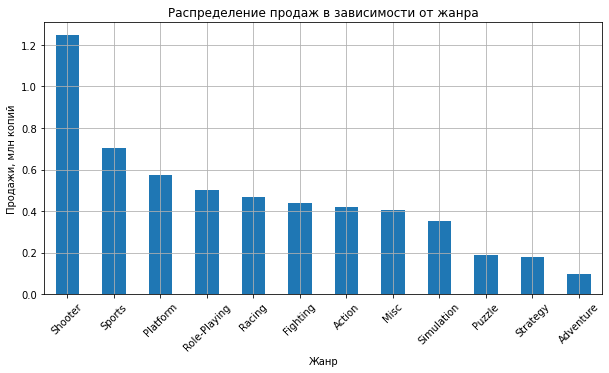

In [41]:
(
    act_df.groupby('genre')['total_sales'].mean().sort_values(ascending=False)
          .plot(
              kind='bar',
              grid=True,
              figsize=(10,5),
              rot=45,
              title='Распределение продаж в зависимости от жанра',
              xlabel='Жанр',
              ylabel='Продажи, млн копий'
          )
);

В среднем самые большие продажи у жанра _Shooter_, а самые низкие у _Adventure_. На втором месте находится жанр _Sports_, чьи продажи в среднем почти в два раза ниже, чем у топового _Shooter_. Также одни из самых низких продаж у _Puzzle_ и _Strategy_ - менее 200 тысяч копий. У остальных жанров средние продажи держаться в среднем на уровне 400 тысяч копий.

_Puzzle_ и _Strategy_ в действительности мало создаются и приносят небольшие продажи. А вот _Shooter_ не смотря на то, что количество созданных игр почти в 4 раза меньше, чем у _Action_, обгоняет всех по продажам - свыше 1.2 млн копий.

### Промежуточные выводы

<u>Периоды:</u>
- До 1990 года количество выпущенных игр держалось на одном уровне
- С 1990 по 2008 год происходит достаточно резкий рост количества выпускаемых игр, с 2009 года начинается постепенный спад
- Самые большие продажи были у `PS2`, а самые маленькие у `PCFX`
- Примерно каждые 5 лет исчезают старые платформы и появляются новые 
- Одна платформа в среднем существует около 10 лет
- За актуальный период для прогноза на 2017 год были взяты годы 2013-2016

<u>Платформы:</u>
- Лидирующие платформы по продажам в актуальном периоде: `PS4`, `XOne`, `X360` и `WiiU`
- Потенциально прибыльными платформами могут быть `PS4`, `WiiU` и `3DS`
- Платформы `PS3`, `PS4`, `X360` и `3DS` выбиваются по продажам, их значения продаж доходят до 15-20 млн копий
- В среднем продажи в актуальном периоде по всем платформам находятся на уровне около 0.2 млн копий или 200 тысяч копий
- Самое высокое среднее значение продаж у платформы `X360`, а самое низкое у `PSP`

<u>Оценки пользователей и критиков:</u>
- Оценки пользователей не влияют на продажи
- Чем выше оценка критиков, тем больше продажи, однако данная связь не достаточно сильная
- Больше доля продаж у игр, которые оценивали пользователи и критики, нежели у игр без оценок

<u>Жанры:</u>
- Самый популярный жанр по количеству выпущенных игр это `Action`, а самый непопулярный - `Puzzle`
- Самое большое количество созданных игр у жанра `Action` - около 750 шт., а самое маленькое у `Puzzle` - менее 50 шт.
- В среднем самые большие продажи у жанра `Shooter`, на втором месте `Sports`, а самые низкие у `Adventure`
- Также одни из самых низких продаж у `Puzzle` и `Strategy` 

## Портрет пользователя каждого региона

Создадим сводную таблицу, в которой будет храниться информация о количестве продаж по платформам для каждого региона, а также доля этих продаж.

In [42]:
# Выбираем колонки с продажами в регионах
columns = ['na_sales', 'eu_sales', 'jp_sales']

# Считаем суммарные продажи для каждой платформы по регионам
regions = act_df.groupby('platform')[columns].sum().reset_index()

# Для каждого региона считаем доли продаж по платформам
for col in columns:
    total = sum(act_df[col])
    prefix = col.split('_')[0]
    regions[prefix+'_prop'] = round(regions[col] / total, 2)

# Смотрим результаты
regions

,platform,na_sales,eu_sales,jp_sales,na_prop,eu_prop,jp_prop
0,3DS,38.20,30.96,67.81,0.09,0.08,0.48
1,DS,0.57,0.85,0.00,0.00,0.00,0.00
2,PC,11.11,25.36,0.00,0.03,0.06,0.00
3,PS3,63.50,67.81,23.35,0.15,0.17,0.17
4,PS4,108.74,141.09,15.96,0.25,0.36,0.11
5,PSP,0.00,0.17,3.29,0.00,0.00,0.02
6,PSV,5.04,6.10,18.59,0.01,0.02,0.13
7,Wii,6.56,5.93,0.05,0.01,0.02,0.00
8,WiiU,29.21,19.85,10.88,0.07,0.05,0.08
9,X360,81.66,42.52,0.51,0.19,0.11,0.00


### Самые популярные платформы по регионам

In [72]:
# Смотрим отдельно на топ-5 платформ в регионе Северная Америка
na_platforms = regions[['platform', 'na_prop']].sort_values(by='na_prop', ascending=False) \
                                               .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
na_platforms.loc[5] = ['other', 1-na_platforms['na_prop'].sum()]

na_platforms

,platform,na_prop
0,PS4,0.25
1,XOne,0.21
2,X360,0.19
3,PS3,0.15
4,3DS,0.09
5,other,0.11


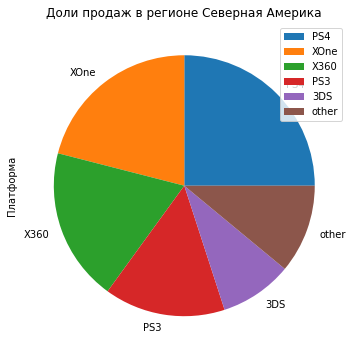

In [80]:
na_platforms.plot.pie(
    y='na_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Северная Америка',
    ylabel='Платформа',
    labels=na_platforms['platform']
);

В Северной Америке в топ-5 платформ входят _PS4_, _XOne_, _X360_, _PS3_, _3DS_. Четверть всех продаж приходится на _PS4_, далее _XOne_ и _X360_ продаются примерно в одинаковом количестве. Самую маленькую долю продаж составляет _3DS_ в доле около 9%.

In [83]:
# Смотрим отдельно на топ-5 платформ в регионе Европа
eu_platforms = regions[['platform', 'eu_prop']].sort_values(by='eu_prop', ascending=False) \
                                               .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
eu_platforms.loc[5] = ['other', 1-eu_platforms['eu_prop'].sum()]

eu_platforms

,platform,eu_prop
0,PS4,0.36
1,PS3,0.17
2,XOne,0.13
3,X360,0.11
4,3DS,0.08
5,other,0.15


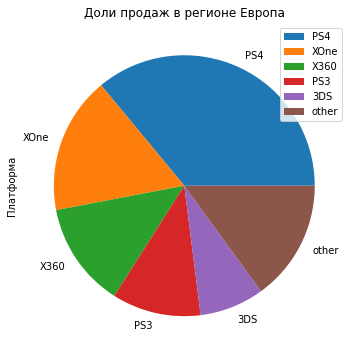

In [84]:
eu_platforms.plot.pie(
    y='eu_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Европа',
    ylabel='Платформа',
    labels=na_platforms['platform']
);

В Европе по прежнему лидируют те же 5 платформ, однако _PS3_ теперь вырывыается вперед перед _XOne_ и _X360_. Продажи _PS4_ занимают уже чуть больше трети всех продаж, а вот _PS3_ продаются в два раза реже. Самую маленькую долю по прежнему занимает _3DS_.

In [85]:
# Смотрим отдельно на топ-5 платформ в регионе Япония
jp_platforms = regions[['platform', 'jp_prop']].sort_values(by='jp_prop', ascending=False) \
                                               .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
jp_platforms.loc[5] = ['other', 1-jp_platforms['jp_prop'].sum()]

jp_platforms

,platform,jp_prop
0,3DS,0.48
1,PS3,0.17
2,PSV,0.13
3,PS4,0.11
4,WiiU,0.08
5,other,0.03


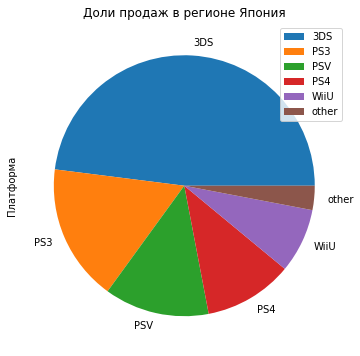

In [90]:
jp_platforms.plot.pie(
    y='jp_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Япония',
    ylabel='Платформа',
    labels=jp_platforms['platform'],
    normalize=True
);

В Японии топ-5 платформ существенно отличается, в него входят _3DS_, _PS3_, _PSV_, _PS4_, _WiiU_. При этом лидирующую позицию занимает отстающий в Америке и Европе _3DS_ с почти половиной доли всех продаж. Доля продаж _PS3_ выше, чем у _PS4_, а самую низкую позицию занимает _WiiU_. 

**Выводы:**
- В Свереной Америке, Европе лидирующая платформа - `PS4`.
- В Японии лидирующая платформа - `3DS` - около половины всех продаж. Сильно остает в других странах.
- Доля продаж `XOne` и `X360` во всех регионах держится примерно на одном уровне.
- Самая высокая доля продаж - около 40% - `PS4` в Северной Америке. В Европе `PS4` занимает около трети всех продаж, а в Японии лишь десятую часть.
- Только в Японии продажи `PS3` обгоняют `PS4`, в остальных странах продажи `PS4` превышают `PS3` почти в два раза.

### Самые популярные жанры

In [46]:
# Выбираем колонки с регионами
columns = ['na_sales', 'eu_sales', 'jp_sales']

# Считаем суммарные продажи по каждому жанру в регионах
genres = act_df.groupby('genre')[columns].sum().reset_index()

# Для каждого жанра считаем доли продаж по каждой платформе
for col in columns:
    total = sum(act_df[col])
    prefix = col.split('_')[0]
    genres[prefix+'_prop'] = round(genres[col] / total, 2)

# Смотрим на результат
genres

,genre,na_sales,eu_sales,jp_sales,na_prop,eu_prop,jp_prop
0,Action,126.05,118.13,40.49,0.29,0.30,0.29
1,Adventure,7.14,8.25,5.82,0.02,0.02,0.04
2,Fighting,15.55,8.55,7.65,0.04,0.02,0.05
3,Misc,27.49,20.04,9.20,0.06,0.05,0.07
4,Platform,18.14,15.58,4.79,0.04,0.04,0.03
5,Puzzle,0.83,1.00,1.18,0.00,0.00,0.01
6,Racing,12.96,20.19,2.30,0.03,0.05,0.02
7,Role-Playing,46.40,36.97,51.04,0.11,0.09,0.36
8,Shooter,109.74,87.86,6.61,0.25,0.22,0.05
9,Simulation,4.86,10.92,4.52,0.01,0.03,0.03


In [91]:
# Смотрим отдельно на топ-5 жанров в регионе Северная Америка
na_genres = genres[['genre', 'na_prop']].sort_values(by='na_prop', ascending=False) \
                                        .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
na_genres.loc[5] = ['other', 1-na_genres['na_prop'].sum()]

na_genres

,genre,na_prop
0,Action,0.29
1,Shooter,0.25
2,Sports,0.15
3,Role-Playing,0.11
4,Misc,0.06
5,other,0.14


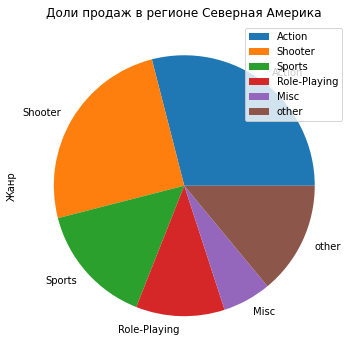

In [93]:
na_genres.plot.pie(
    y='na_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Северная Америка',
    ylabel='Жанр',
    labels=na_genres['genre'],
    normalize=True
);

В Северной Америке топ-5 жанров по продажам занимают: `Action`, `Shooter`, `Sports`, `Role-Playing` и `Misc`. Лидирует `Action` с долей продаж чуть больше четверти, на втором месте `Shooter` с четвертью продаж. Сильнее всего отстаёт `Misc` с долей в 6%.

In [94]:
# Смотрим отдельно на топ-5 жанров в регионе Европа
eu_genres = genres[['genre', 'eu_prop']].sort_values(by='eu_prop', ascending=False) \
                                        .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
eu_genres.loc[5] = ['other', 1-eu_genres['eu_prop'].sum()]

eu_genres

,genre,eu_prop
0,Action,0.30
1,Shooter,0.22
2,Sports,0.15
3,Role-Playing,0.09
4,Misc,0.05
5,other,0.19


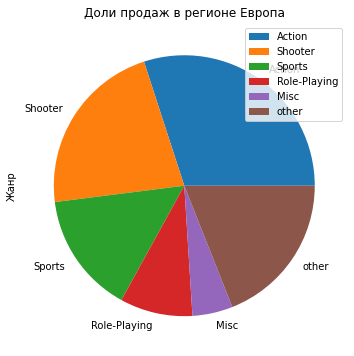

In [96]:
eu_genres.plot.pie(
    y='eu_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Европа',
    ylabel='Жанр',
    labels=eu_genres['genre'],
    normalize=True
);

В Европе в топ-5 жанров входят те же, что и в Америке, приблизительно с теми же долями продаж. По прежнему лидирует `Action` - чуть меньше трети всех продаж. Доля жанра `Shooter` слегка ниже, чем в Америке.

In [97]:
# Смотрим отдельно на топ-5 жанров в регионе Япония
jp_genres = genres[['genre', 'jp_prop']].sort_values(by='jp_prop', ascending=False) \
                                        .reset_index(drop=True)[:5]

# Добавляем оставшуюся долю других платформ
jp_genres.loc[5] = ['other', 1-jp_genres['jp_prop'].sum()]

jp_genres

,genre,jp_prop
0,Role-Playing,0.36
1,Action,0.29
2,Misc,0.07
3,Fighting,0.05
4,Shooter,0.05
5,other,0.18


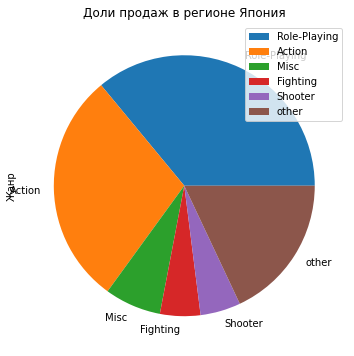

In [98]:
jp_genres.plot.pie(
    y='jp_prop', 
    figsize=(6, 6),
    title='Доли продаж в регионе Япония',
    ylabel='Жанр',
    labels=jp_genres['genre'],
    normalize=True
);

В Японии в топ-5 появляется иной жанр - `Fighting`, а на лидирующей позиции находится `Role-Playing` с долей продаж чуть больше трети - 36%, что на 6% выше, чем в других странах. `Action` занимает второе место и чуть меньше трети всех продаж. Доли продаж всех остальных жанров в регионе очень незначительны и составляют менее 7% на каждый.

**Выводы:**
- Во всех странах одну из лидирующих позиций занимает жанр `Action`
- В Японии лидирует жанр `Role-Playing`, а в Америке и Европе - `Action`
- Во всех странах доля продаж жанра `Action` составляет около трети всех продаж
- В Америке и Европе на втором месте находится жанр `Shooter` - около четверти продаж, однако в Японии данный жанр продается в 4 раза реже - около 5% всех продаж

### Продажи в зависимости от рейтинга ESRB

Создадим сводную таблицу, в которой будет хранится информация о суммарных продажах в зависимости от рейтинга для каждого региона, а также доля этих продаж.

In [102]:
# Выбираем колонки с регионами
columns = ['na_sales', 'eu_sales', 'jp_sales']

# Считаем суммарные продажи для каждого рейтинга по регионам
rating = act_df.groupby(['rating'])[columns].sum()

# Для каждого региона считаем долю продаж по рейтингу
for col in columns:
    total = sum(act_df[col])
    prefix = col.split('_')[0]
    rating[prefix+'_prop'] = round(rating[col] / total, 2)
    
# Обозначаем колонки с долями продаж
props = ['na_prop', 'eu_prop', 'jp_prop']
   
# Отдельно считаем суммарные продажи по играм без выставленного рейтинга
rating.loc['None', :] = act_df[act_df['rating'].isna()][columns].sum()

# Считаем доли продаж для игр без рейтинга по регионам
rating.loc['None', props] = [1-rating[x].sum() for x in props]

# Смотрим на результат
rating

,na_sales,eu_sales,jp_sales,na_prop,eu_prop,jp_prop
rating,,,,,,
E,79.05,83.36,15.14,0.18,0.21,0.11
E10+,54.24,42.69,5.89,0.12,0.11,0.04
M,165.21,145.32,14.11,0.38,0.37,0.10
T,49.79,41.95,20.59,0.11,0.11,0.15
None,89.42,78.91,85.05,0.21,0.20,0.60


No handles with labels found to put in legend.
No handles with labels found to put in legend.


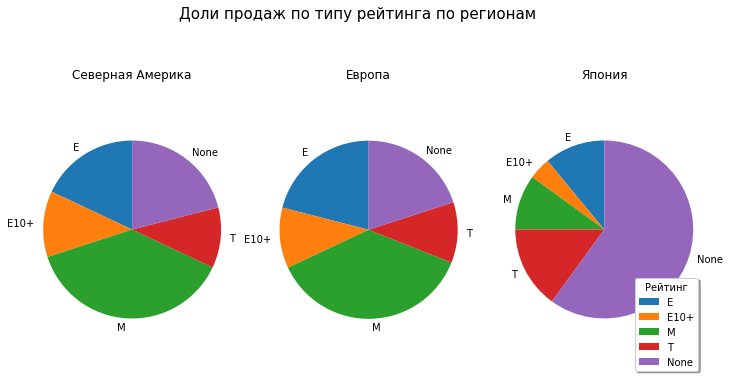

In [154]:
data = rating[props]

fig, axes = plt.subplots(1, len(data.columns), figsize=(12,6))
fig.suptitle("Доли продаж по типу рейтинга по регионам", fontsize=15)

for i, ax in enumerate(fig.axes):
    col = data.iloc[:, i]
    ax = fig.axes[i]
    pcnt_col = col / col.sum() * 100
    
    if pcnt_col.name == 'na_prop':
        ax.set_title('Северная Америка')
    elif pcnt_col.name == 'eu_prop':
        ax.set_title('Европа')
    elif pcnt_col.name == 'jp_prop':
        ax.set_title('Япония')
        
    ax.pie(pcnt_col.values, labels=pcnt_col.index, startangle=90)
    ax.axis("equal")
    plt.legend(loc="lower right", title="Рейтинг", fancybox=True,
               ncol=1, shadow=True)
    
plt.subplots_adjust(top=0.8)
plt.show()

**Выводы:**
- у Америки и Европы одинаковые доли продаж по рейтингам
- В Америке и Европе самая большая доля продаж у рейтинга `M` - Взрослые и находится на уровне 37% продаж
- В Японии большая доля продаж скрывается за играми без выставленного рейтинга (больше половины продаж), из имеющихся лидирует рейтинг `T` - Подросткам - 15% всех продаж
- С уверенностью можно сказать, что в Японии рейтинг не влияет на продажи, а в Америке и Европе влияет, лидирует рейтинг `M` - Взрослые

### Промежуточные выводы

<u>Платформы:</u>
- Лидирующие платформы с самыми большими долями продаж - `PS4` (Америка и Европа) и `3DS` (Япония)
- Доли продаж `XOne` и `X360` держаться примерно на одном уровне
- В Америке и Европе продажи `PS4` превышают продажи `PS3` почти в два раза

<u>Жанры:</u>
- Лидирующую позицию по продажам занимают жанры `Action` (Америка и Европа) и `Role-Playing` (Япония)
- Во всех странах доля продаж жанра `Action` составляет около трети всех продаж
- В Америке и Европе на втором месте находится жанр `Shooter` - около четверти продаж

<u>Рейтинги:</u>
- В Америке и Европе рейтинг влияет на продажи и лидируют продажи игр в рейтинге `M` - Взрослые (около 37% продаж)
- В Японии рейтинг не влияет на продажи, но из имеющихся лидирует `T` - Подросткам

## Проверка гипотез

### Гипотеза 1

**Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые.**

Сформулируем нулевую и альтернативную гипотезы:

**H0** - средний пользовательский рейтинг `XOne` **равен** среднему пользовательскому рейтингу `PC`

**H1** - средний пользовательский рейтинг `XOne` **не равен** среднему пользовательскому рейтингу `PC`

Будем проводить двувыборочный t-тест для двух независимых выборок.

In [60]:
# Выберем только те записи, в которых имеется оценка от пользователей
act_with_score_df = act_df.query('user_score_type == "with_score"')

# Сформируем выборки
xone_score = act_with_score_df.query('platform == "XOne"')['user_score']
pc_score = act_df.query('platform == "PC"')['user_score']

print(f'Размер выборки по Xone: {xone_score.shape[0]}')
print(f'Размер выборки по PC: {pc_score.shape[0]}\n')

print(f'Средняя пользовательская оценка платформы XOne: {round(xone_score.mean(), 2)}')
print(f'Средняя пользовательская оценка платформы PC: {round(xone_score.mean(), 2)}\n')

# Выбираем уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(xone_score, pc_score, alternative='two-sided')

print(f'p-значение: {results.pvalue}\n')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Размер выборки по Xone: 182
Размер выборки по PC: 189

Средняя пользовательская оценка платформы XOne: 6.52
Средняя пользовательская оценка платформы PC: 6.52

p-значение: 1.1403570399989461e-08

Отвергаем нулевую гипотезу


**Вывод:** Средние пользовательские рейтинги платформ `XOne` и `PC` **разные**.

### Гипотеза 2

**Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.**

Сформулируем нулевую и альтернативную гипотезы:

**H0** - средний пользовательский рейтинг `Action` **равен** среднему пользовательскому рейтингу `Sports`

**H1** - средний пользовательский рейтинг `Action` **не равен** среднему пользовательскому рейтингу `Sports`

Будем проводить двувыборочный t-тест для двух независимых выборок.

In [64]:
# Выберем только те записи, в которых имеется оценка от пользователей
act_with_score_df = act_df.query('user_score_type == "with_score"')

# Сформируем выборки
action_score = act_with_score_df.query('genre == "Action"')['user_score']
sports_score = act_df.query('genre == "Sports"')['user_score']

print(f'Размер выборки по Action: {action_score.shape[0]}')
print(f'Размер выборки по Sports: {sports_score.shape[0]}\n')

print(f'Средняя пользовательская оценка жанра Action: {round(action_score.mean(), 2)}')
print(f'Средняя пользовательская оценка жанра Sports: {round(sports_score.mean(), 2)}\n')

# Выбираем уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(action_score, sports_score, alternative='two-sided')

print(f'p-значение: {results.pvalue}\n')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Размер выборки по Action: 389
Размер выборки по Sports: 214

Средняя пользовательская оценка жанра Action: 6.84
Средняя пользовательская оценка жанра Sports: 3.92

p-значение: 5.944315797678289e-56

Отвергаем нулевую гипотезу


**Вывод:** Средние пользовательские рейтинги жанров `Action` и `Sports` действительно **разные**.

## Итоги

**Целью исследования являлось:**

Используя исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы, выявить определяющие успешность игры закономерности. Выработать принцип работы с данными для построения прогнозов и построить прогноз на 2017 год.

**По итогам предварительной обработки данных были следаны следующие наблюдения:**

- Имеется около 50% записей с оценкой пользователей, 40% без оценки пользователей и 10% с оценкой _tbd_
- Приблизительно у половины игр отсутствует оценка от критиков
- Записи с устаревшим рейтингом `K-A` были заменены на современный `E`
- Рейтинг имеется у приблизительно 60% игр
- Максимальное количество продаж составляет 82.5 млн копий

**Результаты исследовательского анализа данных:**

- Примерно каждые 5 лет исчезают старые платформы и появляются новые 
- Одна платформа в среднем существует около 10 лет

**Приницп работы с даными:**

Для построения прогноза необходимо проанализировать данные за последние 3-5 лет, обращая внимание на последнюю смену платформ. Брать период, который начинается с последней смены платформ, предшествующей анализируемому периоду.

> **За актуальный период для построения прогноза на 2017 год были выбраны года 2013-2016. Все дальнейшие результаты исследования опирались на данный актуальный период.**

<u>Общие наблюдения:</u>
- Потенциально прибыльными платформами могут быть `PS4`, `WiiU` и `3DS`
- Самое высокое среднее значение продаж у платформы `X360`, а самое низкое у `PSP`
- Оценки пользователей не влияют на продажи
- Больше доля продаж у игр, которые оценивали пользователи и критики, нежели у игр без оценок
- Чем выше оценка критиков, тем больше продажи, однако данная связь не достаточно сильная
- Самый популярный жанр по количеству выпущенных игр это `Action`, а самый непопулярный - `Puzzle`

<u>В Северной Америке и Европе по продажам:</u>
- Лидирующая платформа - `PS4`, на втором месте `XOne` и `X360`
- Лидирующий жанр - `Action`, на втором месте `Shooter`
- Лидирующий рейтинг - `M` - Взрослые
- Потенциально прибыльными могут быть также `PS3` и `3DS`
- Самый не популярный жанр - `Puzzle`
- Самые низкие продажи также у `Strategy` и `Adventure`

**Прогноз для Северной Америки и Европы:**

> В 2017 году стоит уделить внимание играм в жанре `Action & Shooter` в рейтинге `M` - Взрослые на платформе `PS4`. Дополнительно можно обратить внимание на оценки критиков, но не стоит полностью на них опираться.

<u>В Японии по продажам:</u>
- Лидирующая платформа - `3DS` (около половины всех продаж), на втором месте `PS3`
- Лидирующий жанр - `Role-Playing`, на втором месте `Action`
- Рейтинг игр не влияет на продажи, из имеющихся лидирует `T` - Подросткам
- Продажи `PS3` опережают продажи `PS4` на 5%
- Потенциально прибыльная платформа `3DS`
- В отличие от Америки и Европы в топ-5 жанров входит `Fighting`

**Прогноз для Японии:**

> В 2017 году стоит уделить внимание играм в жанре `Role-Playing & Action` в любом рейтинге на платформе `3DS`. Дополнительно можно обратить внимание на оценки критиков, но не стоит полностью на них опираться.

<u>Дополнительные наблюдения:</u>
- Средние пользовательские рейтинги платформ `XOne` и `PC` разные
- Средние пользовательские рейтинги жанров `Action` и `Sports` разные